In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.basic2 import Basic2
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

### Initialize Task

In [2]:
experiment = 'interactive'
name = 'basic'

In [3]:
dt = 10
tau = 50
T = 3000
N_batch = 50
N_rec = 100

In [4]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch)

### Set up parameters

In [5]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
###############################################
## We are going to change this noise 
###############################################
network_params['rec_noise'] = 2

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [6]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)

### Train Model

In [7]:
trials = 50000
train_params = {}
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None
###################################################
## Change the name of the save path
###################################################

train_params['save_weights_path'] =  "./weights/basic2_recNoise" + str(network_params['rec_noise']) + "itr" + str(trials)


In [8]:
losses, initialTime, trainTime = model.train(task, train_params)
#####################################################
## save losses
#####################################################

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 1000, Minibatch Loss= 0.062492
Iter 2000, Minibatch Loss= 0.114428
Iter 3000, Minibatch Loss= 0.141858
Iter 4000, Minibatch Loss= 0.164871
Iter 5000, Minibatch Loss= 0.191711
Iter 6000, Minibatch Loss= 0.198949
Iter 7000, Minibatch Loss= 0.207546
Iter 8000, Minibatch Loss= 0.221829
Iter 9000, Minibatch Loss= 0.216286
Iter 10000, Minibatch Loss= 0.226600
Iter 11000, Minibatch Loss= 0.207357
Iter 12000, Minibatch Loss= 0.201651
Iter 13000, Minibatch Loss= 0.194884
Iter 14000, Minibatch Loss= 0.198089
Iter 15000, Minibatch Loss= 0.062032
Iter 16000, Minibatch Loss= 0.068319
Iter 17000, Minibatch Loss= 0.041008
Iter 18000, Minibatch Loss= 0.053227
Iter 19000, Minibatch Loss= 0.054600
Iter 20000, Minibatch Loss= 0.034312
Iter 21000, Minibatch Loss= 0.063704
Iter 22000, Minibatch Loss= 0.056317
Iter 23000, Minibatch Loss= 0.083048
Iter 24000, Minibatch Loss= 0.058141
Iter 25000, Minibatch Loss=

In [12]:
loss_name = "./losses/basic2_recNoise" + str(network_params['rec_noise']) + "itr" + str(trials) + "losses"
with open('losses.txt', 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Text(0.5, 1.0, 'Loss During Training')

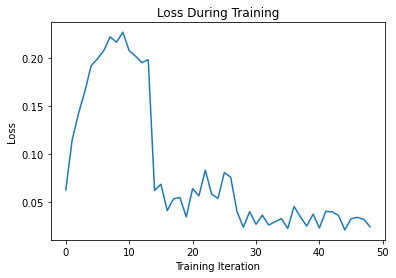

In [21]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

### Test on 5000 trials to examine performance

In [11]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [12]:
for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


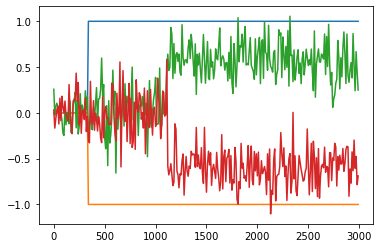

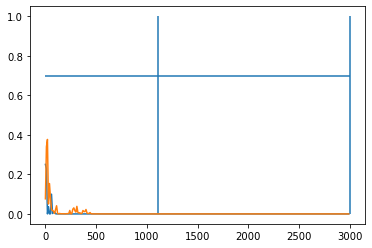

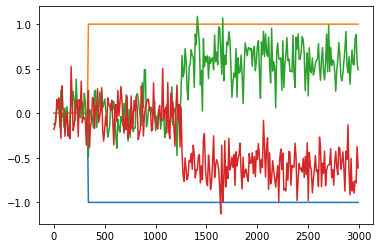

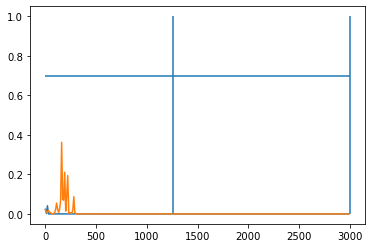

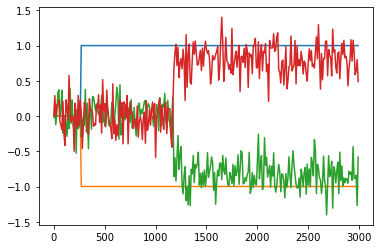

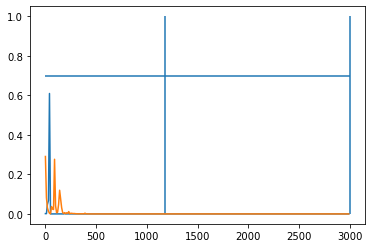

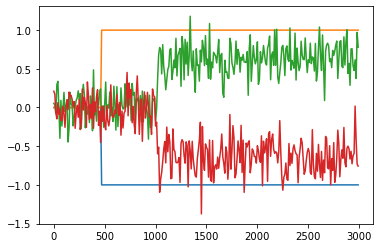

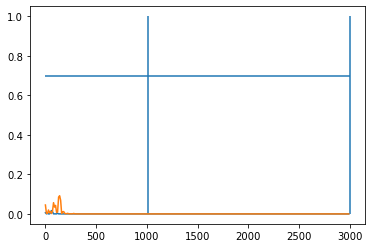

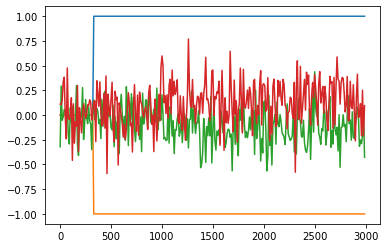

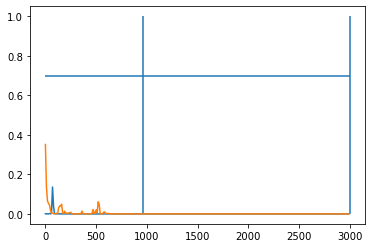

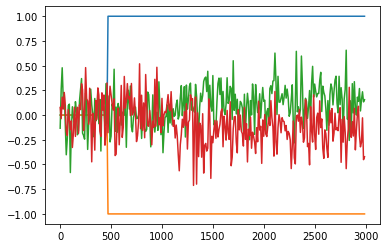

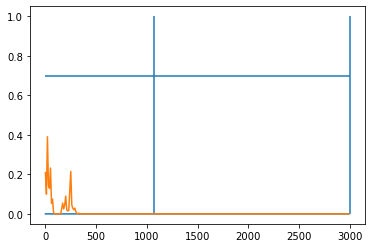

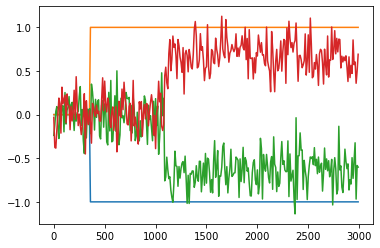

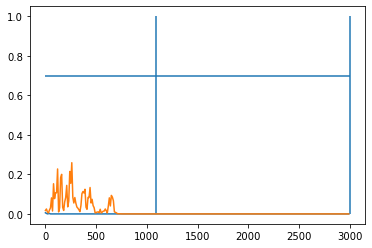

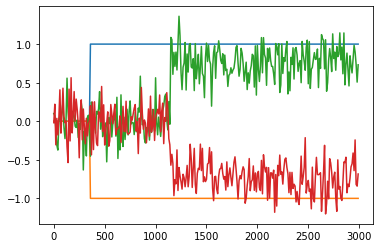

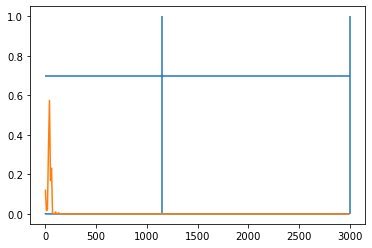

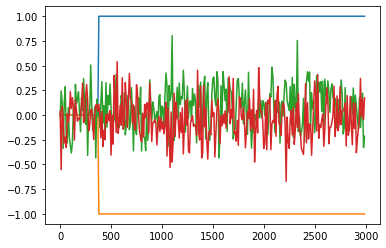

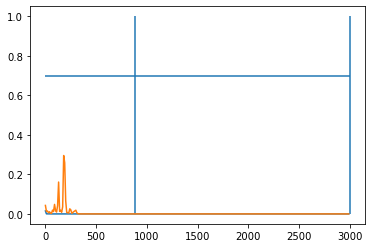

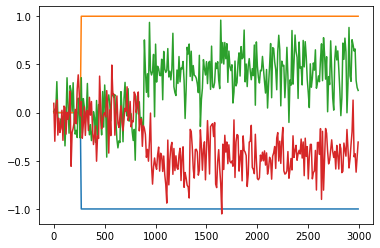

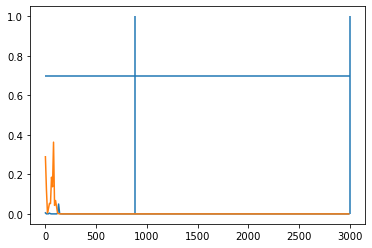

In [13]:
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10):
    plt.figure()
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 3])

    plt.figure()
    plt.plot(np.arange(0, 3000, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, 3000, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, 3000)

In [14]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

#############################################
## Save checker_df with a specific name 
#############################################
resultPath = "./resultData/summary_recNoise" + str(network_params['rec_noise']) + "itr" + str(trials) + ".csv"
 
checker_df.to_csv(resultPath)

In [15]:
checker_mean

,coherence_bin,trial,coherence,green_side,correct_side,target_onset,checker_onset,decision,green_decision,decision_time,correct_decision
0,-0.9,2507.815385,-0.872534,0.461538,0.538462,374.784615,753.700000,0.092308,0.584615,1520.669231,0.415385
1,-0.8,2526.675373,-0.799401,0.432836,0.567164,378.832090,737.764925,0.100746,0.548507,1557.470149,0.451493
2,-0.7,2393.246667,-0.697813,0.510000,0.490000,372.990000,739.796667,0.086667,0.496667,1560.846667,0.503333
3,-0.6,2565.984496,-0.599715,0.507752,0.492248,368.480620,747.364341,0.077519,0.476744,1634.930233,0.523256
4,-0.5,2526.023810,-0.501829,0.465986,0.534014,370.496599,748.139456,0.102041,0.547619,1557.010204,0.452381
5,-0.4,2459.375479,-0.396926,0.501916,0.498084,371.459770,746.402299,0.068966,0.498084,1567.080460,0.501916
6,-0.3,2569.746377,-0.302655,0.474638,0.525362,377.528986,747.532609,0.101449,0.554348,1480.518116,0.445652
7,-0.2,2575.495935,-0.199778,0.495935,0.504065,373.121951,743.605691,0.089431,0.504065,1581.565041,0.495935
8,-0.1,2616.589474,-0.100483,0.498246,0.501754,372.291228,753.691228,0.084211,0.480702,1559.912281,0.519298
9,0.0,2520.043796,-0.001648,0.467153,0.532847,375.375912,750.759124,0.072993,0.525547,1609.156934,0.467153


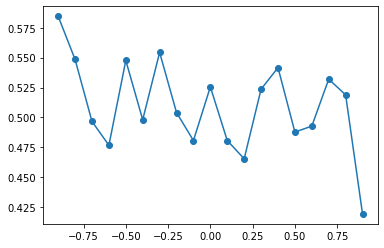

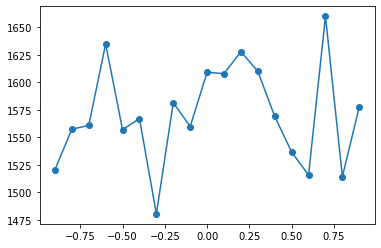

In [16]:
plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

# RT within same coherence

In [17]:
# for i in [0.9,0.7,0.5,0.3,0.1,0]:
#     a = checker_df['coherence_bin'] == i
#     groupCo = checker_df.loc[a,:]
#     RT = groupCo["decision_time"]
#     plt.figure()
#     plt.hist(RT)
#     plt.title("Coherence: " + str(i))

In [18]:
model.destruct()

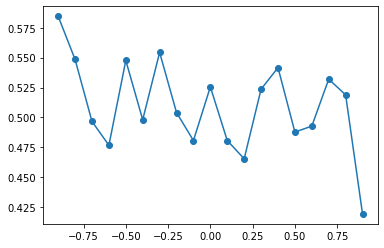

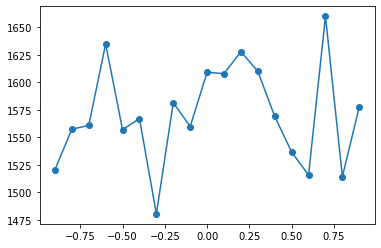

In [19]:
## test stored summary
df = pd.read_csv(resultPath)
test_mean = df.groupby('coherence_bin').mean().reset_index()
plt.figure()
plt.plot(test_mean['coherence_bin'], test_mean['green_decision'])
plt.scatter(test_mean['coherence_bin'], test_mean['green_decision'])

plt.figure()
plt.plot(test_mean['coherence_bin'], test_mean['decision_time'])
plt.scatter(test_mean['coherence_bin'], test_mean['decision_time'])

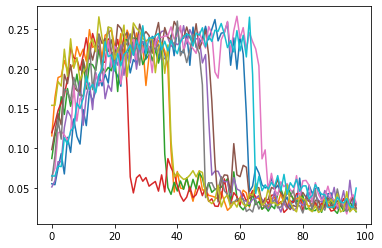

In [26]:
for i in range(10):
    readFileName = "./losses/basic2_recNoise2round" + str(i) + ".txt"
    df = pd.read_csv(readFileName, delimiter = "\t")
    plt.plot(df)
    
    
# [0.5, 1, 1.5, 2, 2.2, 2.4, 2.6, 2.8, 3]



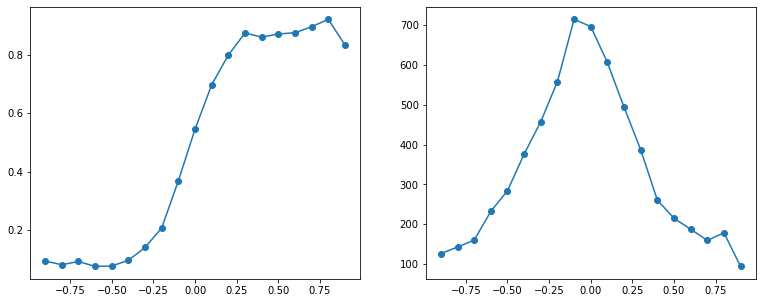

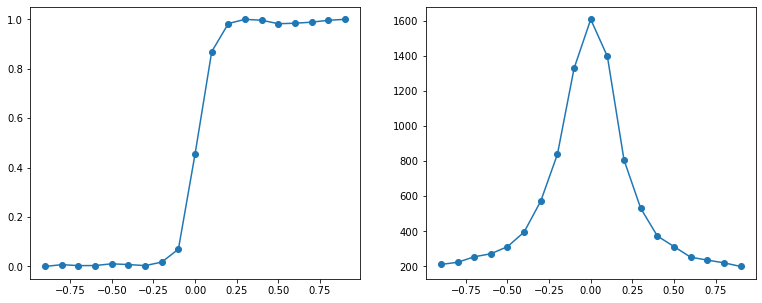

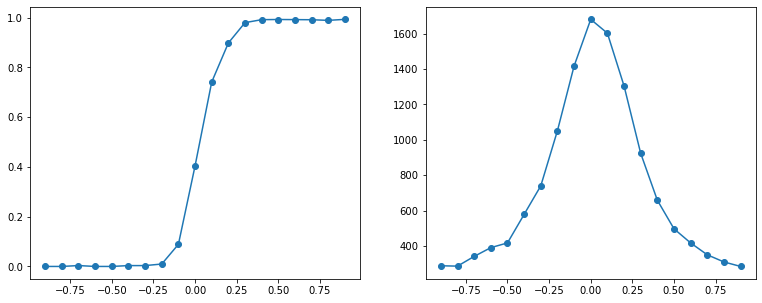

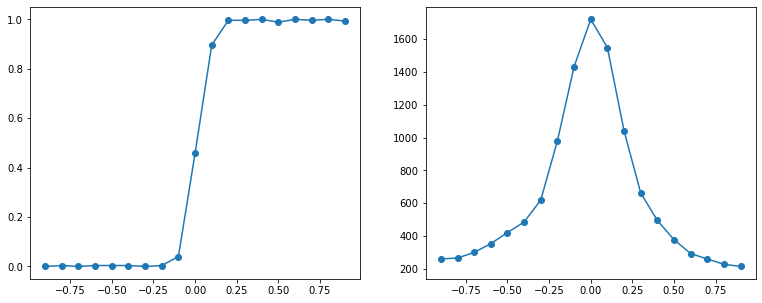

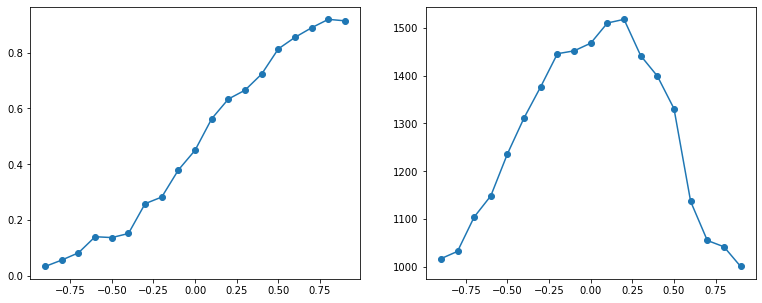

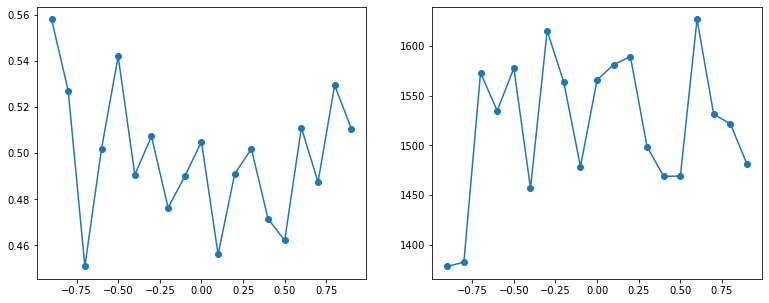

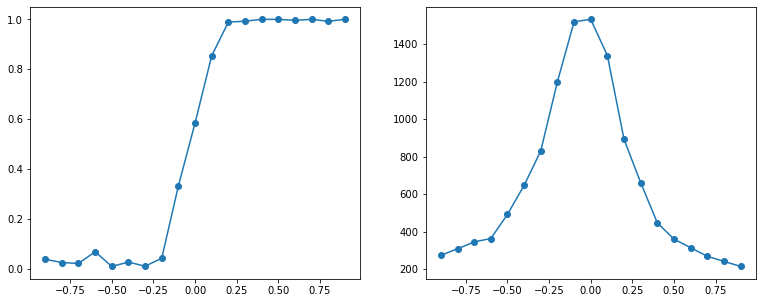

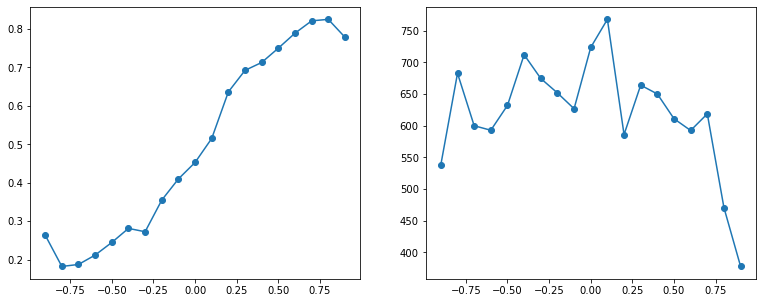

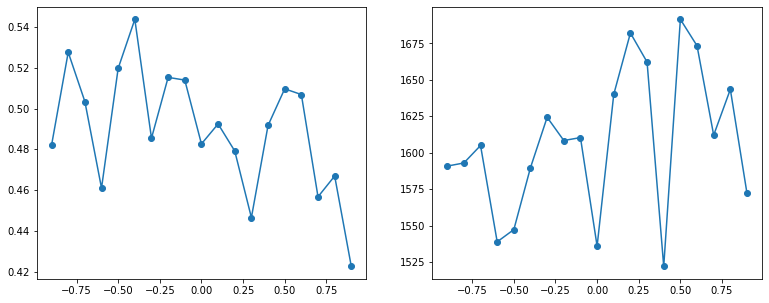

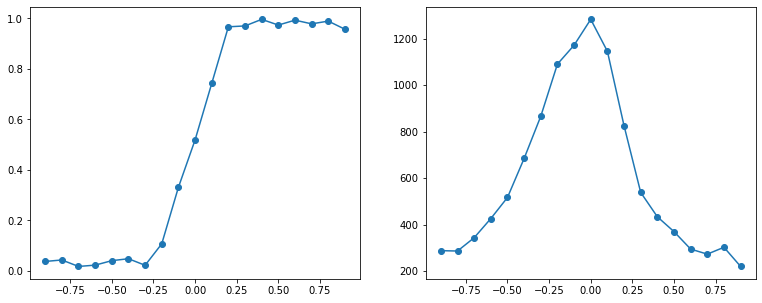

In [28]:
for i in range(10):
    resultFile = "./resultData/summary_recNoise2.2round" + str(i) + ".csv"
    checker_df = pd.read_csv(resultFile)

    checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

    plt.figure(figsize=(13, 5))
    plt.subplot(1,2,1)
    plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
    plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

    plt.subplot(1,2,2)
    plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
    plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

